<center>
    <h1>Time Series Forecasting using Bidirectional LSTM</h1>
    <h3>Name: Prerak Shah, Sai Sri Meghana Dharmapuri</h3>
</center>

# 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
df_stock = pd.read_csv('CSC215_P2_Stock_Price.csv')

In [3]:
df_stock.shape

(4392, 7)

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


# Data Cleaning 

# 2. Drop Date and Adj_Close columns

In [5]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [6]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()
#df_stock_new.['y'] = df_stock_new.['Close']

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [7]:
df_stock_new.shape

(4392, 5)

In [8]:
df_stock.shape

(4392, 7)

# 3. Removing null values 

In [9]:
df_stock_new.shape

(4392, 5)

In [10]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [12]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


# 4. Normalizing the columns 

In [13]:
#Normalizing the training numeric values using zscore
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [14]:
x=df_stock_new.as_matrix(columns=['Open','High','Low','Volume','Close'])

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:
x.shape

(4392, 5)

In [16]:
df_stock_new.shape

(4392, 6)

In [17]:
#y=df_stock_new.as_matrix(['y'])

In [18]:
y=df_stock_new['y'].tolist()

In [19]:
y=np.array(y)

In [20]:
y.shape

(4392,)

# 4. Data Transformation

In [21]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [22]:
SEQUENCE_SIZE = 7
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))

Shape of x_seq: (4385, 7, 1, 5)
Shape of y_seq: (4385,)


In [23]:
x_seq_3d = x_seq.reshape(4385,7,5)

# 5. Splitting the dataset into test and train data ( 70% train & 30% test )

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_3d,y_seq,test_size=0.30,random_state=0)

In [25]:
X_train.shape

(3069, 7, 5)

In [26]:
len(X_train)

3069

In [27]:
X_test.shape

(1316, 7, 5)

In [28]:
Y_train.shape

(3069,)

In [29]:
Y_test.shape

(1316,)

In [30]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

# <center> <h1>Bidirectional LSTM</h1></center>

With Adam optimizer and relu activation 

Using TensorFlow backend.


Train on 3069 samples, validate on 1316 samples
Epoch 1/200
 - 8s - loss: 1176.1583 - val_loss: 562.4222
Epoch 2/200
 - 3s - loss: 335.5579 - val_loss: 133.4421
Epoch 3/200
 - 3s - loss: 74.6560 - val_loss: 23.8266
Epoch 4/200
 - 3s - loss: 15.2757 - val_loss: 7.0718
Epoch 5/200
 - 3s - loss: 7.2742 - val_loss: 3.0065
Epoch 6/200
 - 3s - loss: 2.5982 - val_loss: 2.4449
Epoch 7/200
 - 3s - loss: 2.0630 - val_loss: 2.5959
Epoch 8/200
 - 3s - loss: 2.2038 - val_loss: 2.5684
Epoch 9/200
 - 3s - loss: 2.2202 - val_loss: 2.1638
Epoch 10/200
 - 2s - loss: 2.1505 - val_loss: 2.6043
Epoch 11/200
 - 7s - loss: 1.9188 - val_loss: 1.9644
Epoch 12/200
 - 7s - loss: 2.0148 - val_loss: 2.4939
Epoch 13/200
 - 3s - loss: 1.5068 - val_loss: 2.0763
Epoch 14/200
 - 3s - loss: 1.6883 - val_loss: 2.4547
Epoch 15/200
 - 3s - loss: 1.4420 - val_loss: 1.6484
Epoch 16/200
 - 4s - loss: 1.4169 - val_loss: 2.5483
Epoch 17/200
 - 3s - loss: 2.0605 - val_loss: 1.5756
Epoch 18/200
 - 3s - loss: 1.4303 - val_loss: 1.

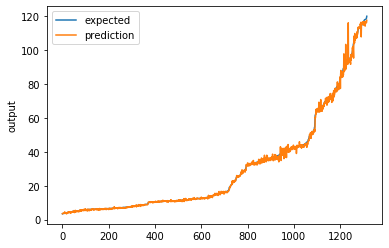

In [31]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from random import random
from sklearn import metrics

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(7,5)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
model.load_weights('best_weights_LSTM.hdf5')

pred = model.predict(X_test)
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)



With Adam optimizer and sigmoid activation

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
 - 9s - loss: 1725.5751 - val_loss: 1582.4622
Epoch 2/200
 - 3s - loss: 1575.3124 - val_loss: 1509.3404
Epoch 3/200
 - 3s - loss: 1505.8649 - val_loss: 1445.0722
Epoch 4/200
 - 3s - loss: 1443.9611 - val_loss: 1387.0256
Epoch 5/200
 - 3s - loss: 1388.0022 - val_loss: 1333.9289
Epoch 6/200
 - 3s - loss: 1336.7017 - val_loss: 1286.3931
Epoch 7/200
 - 3s - loss: 1289.7596 - val_loss: 1242.3922
Epoch 8/200
 - 3s - loss: 1246.8714 - val_loss: 1201.7093
Epoch 9/200
 - 3s - loss: 1207.6988 - val_loss: 1165.0640
Epoch 10/200
 - 3s - loss: 1171.9919 - val_loss: 1131.9146
Epoch 11/200
 - 3s - loss: 1139.4857 - val_loss: 1101.8495
Epoch 12/200
 - 3s - loss: 1110.0266 - val_loss: 1074.4137
Epoch 13/200
 - 3s - loss: 1083.3712 - val_loss: 1049.9319
Epoch 14/200
 - 3s - loss: 1059.4480 - val_loss: 1027.5947
Epoch 15/200
 - 3s - loss: 1037.8957 - val_loss: 1008.0698
Epoch 16/200
 - 3s - loss: 1018.6940 - val_loss: 990.5384
Epoch 17/200
 - 2s

Epoch 147/200
 - 4s - loss: 1.2585 - val_loss: 1.5167
Epoch 148/200
 - 4s - loss: 1.1524 - val_loss: 1.2360
Epoch 149/200
 - 5s - loss: 0.9568 - val_loss: 1.2013
Epoch 150/200
 - 4s - loss: 1.0229 - val_loss: 1.5604
Epoch 151/200
 - 4s - loss: 0.9715 - val_loss: 1.2114
Epoch 152/200
 - 4s - loss: 0.8908 - val_loss: 1.1679
Epoch 153/200
 - 4s - loss: 0.8784 - val_loss: 1.2579
Epoch 154/200
 - 4s - loss: 0.8839 - val_loss: 1.1572
Epoch 155/200
 - 4s - loss: 0.8695 - val_loss: 1.1724
Epoch 156/200
 - 5s - loss: 0.9091 - val_loss: 1.1588
Epoch 157/200
 - 5s - loss: 0.8495 - val_loss: 1.1546
Epoch 158/200
 - 4s - loss: 0.7756 - val_loss: 1.2602
Epoch 159/200
 - 5s - loss: 0.8286 - val_loss: 1.1117
Epoch 160/200
 - 4s - loss: 0.8099 - val_loss: 1.1234
Epoch 161/200
 - 4s - loss: 0.8123 - val_loss: 1.3040
Epoch 162/200
 - 4s - loss: 0.8111 - val_loss: 1.2557
Epoch 163/200
 - 4s - loss: 0.8008 - val_loss: 1.4712
Epoch 164/200
 - 3s - loss: 0.7794 - val_loss: 1.2057
Epoch 00164: early stopping


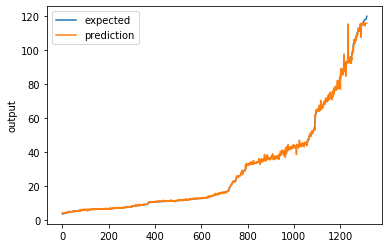

In [32]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(7,5)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
model.load_weights('best_weights_LSTM.hdf5')

pred = model.predict(X_test)
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)



With Adam optimizer and tanh activation

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
 - 15s - loss: 1497.4575 - val_loss: 1307.9200
Epoch 2/200
 - 4s - loss: 1270.6858 - val_loss: 1179.9993
Epoch 3/200
 - 4s - loss: 1146.1003 - val_loss: 1063.0086
Epoch 4/200
 - 5s - loss: 1037.7228 - val_loss: 965.6124
Epoch 5/200
 - 5s - loss: 943.4929 - val_loss: 877.5451
Epoch 6/200
 - 5s - loss: 859.8888 - val_loss: 798.9927
Epoch 7/200
 - 4s - loss: 785.7159 - val_loss: 729.3681
Epoch 8/200
 - 4s - loss: 719.5968 - val_loss: 668.5373
Epoch 9/200
 - 5s - loss: 660.8611 - val_loss: 613.7424
Epoch 10/200
 - 5s - loss: 608.5215 - val_loss: 565.0652
Epoch 11/200
 - 5s - loss: 561.9859 - val_loss: 521.4624
Epoch 12/200
 - 4s - loss: 520.0596 - val_loss: 482.6413
Epoch 13/200
 - 4s - loss: 482.0689 - val_loss: 446.8511
Epoch 14/200
 - 4s - loss: 447.3058 - val_loss: 415.1995
Epoch 15/200
 - 4s - loss: 415.6078 - val_loss: 385.1190
Epoch 16/200
 - 4s - loss: 386.3891 - val_loss: 357.0116
Epoch 17/200
 - 4s - loss: 359.2789 - val

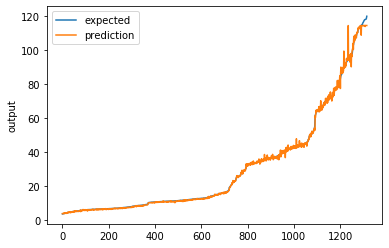

In [33]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(7,5)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
model.load_weights('best_weights_LSTM.hdf5')

pred = model.predict(X_test)
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

